# test ABM with standard test functions


In [1]:
import numpy as np
import scipy
import pandas as pd
from scipy.stats import chi
# from opteval import benchmark_func as bf
import matplotlib
import os

#for server:
matplotlib.use('Agg')

#for retina display:
# %config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import copy
import time as timer
import threading
import pickle

import multiprocessing
from multiprocessing import Pool
# from playsound import playsound
# from sklearn import linear_model

## Helper Functions

In [2]:
def cp(x): #make a copy instead of reference
    return copy.deepcopy(x)

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def isNaN(num):
    return num != num

def mean(x):
    return np.mean(x)

def norm(x):
    return float(np.linalg.norm(x))

def dist(x,y):
    return np.linalg.norm(np.array(x)-np.array(y))

def bounds(x,low,high):
    if x > high:
        return high
    if x < low:
        return low
    return x

def pScore(A,B):#ANOVA of 2 independent samples: are differences significant?
    _, p = scipy.stats.ttest_ind(A,B)
    return p 

def aiColor(ai): #red for innovators, blue for adaptors
    ai01 = bounds((ai - 40)/ 120,0,1)
    red = ai01
    blue = 1 - ai01
    return (red,0,blue)

def makeAiScore():
    ai = np.random.normal(97,17)
    ai = bounds(ai, 40,150)
    return ai

def makeIqScore(): #this IQ ranges from 0 to 1, bc it is basically efficiency
    iq = np.random.normal(0.5,0.2)
    iq = bounds(iq, 0.1,1.0)
    return iq

def pickWorseScore(betterScore,worseScore,temperature):
    if temperature <=1E-6: #never pick worse answers, and avoid devide by 0
        return False
    if np.random.uniform(0,1) < np.exp((betterScore-worseScore)/temperature):  #
        return True 
    return False

def calculateDecay(steps,T0=1.0,Tf=0.01):
    if T0<=Tf or T0<=0: 
        return 0
    return (Tf / float(T0) ) ** (1/steps)
  
def calculateAgentDecay(agent, steps):
    E_N = normalizedE(agent.kai.E)
    E_transformed = np.exp((E_N*-1)+2)
    startEndRatio = bounds(1/E_transformed, 1E-10,1)
#     print("ratio: %s" % startEndRatio)
    T0 = agent.temp
    TF = T0 * startEndRatio
    return calculateDecay(steps,T0,TF)#, startEndRatio

# def chaching():
#     playsound("/Users/samlapp/SAE_ABM/missionComplete.wav")

In [3]:
# es = []
# kais = []
# ratios = []
# for i in range(500):
#     a = Agent()
#     d, ratio = calculateAgentDecay(a,100)
#     es.append(a.kai.E)
#     kais.append(a.kai.KAI)
#     ratios.append(ratio)
# plt.scatter(es, ratios)
# plt.show()
# plt.scatter(kais, ratios)

## global constants and parameters

In [4]:
complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
shareAcrossTeams = True
commBonus = 10 #increasing the communication bonus makes successful communication more likely
commRange = 180
pCommTime = None
selfBias = 0 #increasing self bias will make agents choose their solutions more over others
startRange = 1
nDims = 56

SO_STRENGTH = 10
RG_STRENGTH = 10
TEAM_MEETING_COST = 1 #1 turn
ROUGHNESS = .025
w_global = 100

VERBOSE = False
showViz = False

AVG_SPEED = 7.0E-3
SD_SPEED = 7.0E-4
MIN_SPEED = 1.0E-4
AVG_TEMP = 1
SD_TEMP = 0.5
UNIFORM_SPEED = False
UNIFORM_TEMP = False
startPositions = None

steps = 500 #0 #100
nAgents = 33
# constructor = Wteinway
pComm = 0.2
pCommTime = None
meetingTimes = steps #have one meeting at the end
startHavingMeetings = 0

# Objectives

In [5]:
#implement four classic test optimization functions, and my tuneable roughness one

In [6]:
def objectiveTune(x,roughness=.05,w=100):
    a = roughness
    b = 2
    x = np.array(x)
    xEach = -1*a*np.sin((x*w+np.pi/2)) + b*(x*1.5)**2 + roughness #min is zero at zero vector
    y = sum(xEach)
    return y

In [7]:
def constrain(x):
    for i in range(len(x)):
        x[i] = bounds(x[i],-1,1)
    return x

In [8]:
x = np.linspace(-1,1,1000)
for ROUGHNESS in [0,.2,3]:#np.linspace(0,.1,5):#= 0.05
    y=[objectiveTune([xi],ROUGHNESS) for xi in x]
    plt.plot(x,y)

    plt.xlim([-.5,.5])
    plt.ylim([0,2])

In [9]:
x = np.linspace(-1,1,1000)
y=[objectiveTune([xi],0.2) for xi in x]
plt.plot(x,y)

plt.xlim([-.5,.5])
plt.ylim([0,2])
plt.savefig('/Users/samlapp/SAE_ABM/results/problem1.png',dpi=300)
plt.show()


x = np.linspace(-1,1,1000)
y=[objectiveTune([xi],5) for xi in x]
plt.plot(x,y)

plt.xlim([-.5,.5])
plt.ylim([0,20])
plt.savefig('/Users/samlapp/SAE_ABM/results/problem5.png',dpi=300)


## new objective

In [10]:
# # def f1(x,p=1,c=0):
# #     return (x+c)**p
# def generateComposite(ws,ps,cs):
#     return lambda x: np.sum([ws[i]*(x-cs[i])**ps[i] for i in range(len(ws))])

# def generateConstraint(alpha,beta,gamma,i,j):
#     return lambda x: alpha*((x[i]-gamma[0])**2+(x[j]-gamma[1])**2 - beta**2)

# def generateConstraint2(alpha,beta,gamma,nDims):
#     return lambda x: alpha*(sum([(x[i]-gamma[i])**2 for i in range(nDims)]) - beta**2)

# def generateFunctionsNdims(n):
#     allF = []
#     for i in range(n): 
#         ws = np.random.uniform(-1,1,3)
#         ws[2] = ws[2] * 10
#         ps = [3,3,1]
#         cs = np.random.uniform(-1,1,3)
#         f = generateComposite(ws,ps,cs)
#         allF.append(f)
#     return allF

# #constraints: g(x)<= 0
# def generateConstraints(n,nDims):
#     gs = []
#     alphas = [-1,1]
#     for i in range(n):
#         alpha = alphas[i]#np.random.choice([-1,1]) #inside or outside
#         beta = np.random.uniform(.3,.8) #size of circle
#         gamma = np.random.uniform(-.2,.2,nDims)#2 #center of circle
# #         i,j = np.random.choice(range(nDims),2,replace=False) #dimensions to constrain
# #         g = generateConstraint(alpha,beta,gamma,i,j)
#         g = generateConstraint2(alpha,beta,gamma,nDims)
#         gs.append(g)
#     return gs

# def evalX(fs,x,gs=[]):
#     y = 0
#     for i in range(len(x)):
#         f = fs[i]
#         y+= f(x[i])
#         if abs(x[i]) > 1:
#             return 1E18  
        
#     for g in gs: #composite constraints
#         if g(x)>0:
#             return 1E18
#     return y

# def evalXpeacewise(fs,x,gs=[]):
#     y = 0
#     for i in range(len(x)):
#         f = fs[i]
#         y+= f(x[i])
#         if abs(x[i]) > 1:
#             return 1E18
        
#     #make a peacewise domain:
#     inDomain = False
#     for g in gs: #if it satisfies ANY constraint, it passes
#         if g(x)<=0:
#             inDomain = True
#     if not inDomain:
#         return 1E18

#     return y

# # crescentFs = generateFunctionsNdims(nDims)
# # crescentGs = generateConstraints(2,nDims)

# Create Virtual Population with represntative KAI scores 
based on KAI score and subscore dataset provided by Dr. J

In [11]:
kaiDF_DATASET = pd.read_csv("./KAI/KAI_DATA_2018_07_09.csv")
kaiDF_DATASET.columns = ["KAI","SO","E","RG"]
def makeKAI(n=1,asDF=True):
    pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
    if asDF:
        popDF = pd.DataFrame(pop) 
        popDF.columns = kaiDF_DATASET.columns
        return popDF if n>1 else popDF.loc[0]
    else:
        return pop if n>1 else pop[0]
    
# def makeSubscores(kai,n=1,asDF=True):
#     pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
kaiPopulation = makeKAI(100000)
kaiPopulation=kaiPopulation.round()

def findAiScore(kai):
    kai = int(kai)
    a = kaiPopulation.loc[kaiPopulation['KAI'] == kai]
    ind = np.random.choice(a.index)
    me = kaiPopulation.loc[ind]
    return KAIScore(me) #this is a KAIScore object

#calculate speed and temperature based on agents' KAI scores
def calcAgentSpeed(kai):
#     speed = bounds(AVG_SPEED + normalizedAI(kai) * SD_SPEED, MIN_SPEED ,np.inf)
    speed = bounds(np.exp(normalizedAI(kai))* AVG_SPEED, MIN_SPEED ,np.inf)
    return speed

def calcAgentTemp(E):
#     return bounds(AVG_TEMP + normalizedE(E) * SD_TEMP, 0 ,np.inf)
    return np.exp(normalizedE(E)*AVG_TEMP)

#create standardized (not normalized) KAI scores and subscores
def normalizedAI(ai):
    return (ai - kaiDF_DATASET.mean().KAI)/kaiDF_DATASET.std().KAI
def normalizedRG(rg):
    return (rg - kaiDF_DATASET.mean().RG)/kaiDF_DATASET.std().RG
def normalizedE(E):
    return (E - kaiDF_DATASET.mean().E)/kaiDF_DATASET.std().E
def normalizedSO(SO):
    return (SO - kaiDF_DATASET.mean().SO)/kaiDF_DATASET.std().SO

In [12]:
k= range(50,150)
s=[]
for i in k:
    s.append(calcAgentSpeed(i))
plt.scatter(k,s)
calcAgentSpeed(98)

0.007001287448845607

In [13]:
def dotNorm(a,b): #return normalized dot product (how parallel 2 vectors are, -1 to 1)
    if norm(a) <= 0 or norm(b)<= 0:
#         print("uh oh, vector was length zero")
        return 0
    a = np.array(a)
    b = np.array(b)
    dotAB = np.sum(a*b)
    normDotAB = dotAB / (norm(a)*norm(b))
    return normDotAB

def plotCategoricalMeans(x,y):
    categories = np.unique(x)
    means = []
    sds = []
    for c in categories:
        yc = [y[i] for i in range(len(y)) if x[i] == c]
        means.append(np.mean(yc))
        sds.append(np.std(yc))
    plt.errorbar(categories,means,yerr=sds,marker='o',ls='none')
    
    return means

#speed distributions:
dfConstant=1.9
def travelDistance(speed): #how far do we go? chi distribution, but at least go 0.1 * speed
    r = np.max([chi.rvs(dfConstant),0.1]) 
    return r * speed

def memoryWeightsPrimacy(n):
    if n==1:
        return np.array([1])
    weights = np.arange(n-1,-1,-1)**3*0.4 + np.arange(0,n,1)**3
    weights = weights / np.sum(weights)
    return weights

# machinery to save results

In [14]:
def makeParamString():
    s= ""
    s+= "steps: "+ str(steps) + " \n"
    s+= "self-bias: " +str(selfBias)+ " \n"
    s+= "num agents: " +str(nAgents)+ " \n"
    s+= "num teams: " +str(nTeams)+ " \n"
    s+= "num dimensions: " +str(nDims)+ " \n"
    s+= "rg strength: " +str(RG_STRENGTH)+ " \n"
    s+= "so strength: " +str(SO_STRENGTH)+ " \n"
    s+= "repeats: " +str(reps)+ " \n"
    s+= "avg speed: " +str(AVG_SPEED) + " \n"
    s+= "sd speed: " + str(SD_SPEED)+ " \n"
    s+= "min speed: " +str(MIN_SPEED)+ " \n"
    s+= "avg temp: "+ str(AVG_TEMP)+ " \n"
    s+= "sd temp: " +str(SD_TEMP)+ " \n"
    s+= "roughness: " +str(ROUGHNESS)+ " \n"
    return s

class Result:
    def __init__(self):
        self.bestScore = np.inf
        self.bestCurrentScore = np.inf
        self.nMeetings = 0
        self.agentKAIs = []
        
def saveResults(teams,dirName='',url='./results'):
    directory = url+'/'+str(timer.time())+dirName
    os.mkdir(directory)
    
    paramsURL = directory+'/'+'parameters.txt'
    np.savetxt(paramsURL,[makeParamString()], fmt='%s')
    
    teamResults = []
    for team in teams:
        result = Result()
        result.bestScore = team.getBestScore()
        result.bestCurrentScore = team.getBestCurrentScore()
        result.nMeetings = team.nMeetings
        result.agentKAIs = [a.kai for a in team.agents]
        teamResults.append(result)
    rFile = directory+'/'+'results.obj'
    rPickle = open(rFile, 'wb')
    pickle.dump(teamResults, rPickle)
    
    return directory

In [15]:
# directory = saveResults(saveTeams, 'trial')
# filehandler = open(directory+'/results.obj', 'rb')
# returnedObj = pickle.load(filehandler) 

# plt.scatter([0,1],[2,3])
# plt.savefig(directory+'/fig.pdf')

## Agent and Team Classes

In [16]:
class Agent:
    def __init__(self, id=-1):
        self.id = id
        self.score = np.inf
        self.r = np.random.uniform(-1,1,size=nDims)
        self.nmoves = 0
        self.kai = KAIScore()
        self.speed = calcAgentSpeed(self.kai.KAI)
        self.temp = calcAgentTemp(self.kai.E)
        self.iq = 1 #makeIqScore()
        self.memory = [Solution(self.r,self.score,self.id,type(self))]
        self.team = -1
        self.decay = calculateAgentDecay(self,100)
        self.startTemp = cp(self.temp)
        self.startSpeed = cp(self.speed)
        
    def reset(self):
        self.temp = self.startTemp
        self.speed = calcAgentSpeed(self.kai.KAI)
        self.memory = []
        self.r = np.random.uniform(-1,1,size=nDims)
        self.nmoves = 0
        self.score = np.inf
            
    def move(self,soBias=False,groupConformityBias=False,teamPosition=None):
        if np.random.uniform()>self.iq: #I'm just thinking this turn
            return False 
        
#         print("my dimensions:" +str(self.myDims))
        #pick a new direction
        d = np.random.uniform(-1,1,nDims)
        d = d * self.myDims #project onto the dimensions I can move
        dn = np.linalg.norm(d)
        if dn==0: print("divide by zero (dn)")
        #distance moved should be poisson distribution, rn its just my speed
        distance = travelDistance(self.speed) * nDims
        d = d / dn * distance
#         print('considering moving '+str(d) + ' from '+str(self.r))
        candidateSolution = (self.r + d)
        candidateSolution = constrain(candidateSolution)
        
        acceptsNewSolution = self.evaluate(candidateSolution,soBias,groupConformityBias,teamPosition=teamPosition)
        if acceptsNewSolution: 
            self.moveTo(candidateSolution)
            return True
#         self.score = self.f()
        return False

    def moveTo(self, r):
        self.r = r
        self.score = self.f()
        self.memory.append(Solution(self.r,self.score,self.id,type(self)))
        self.nmoves += 1
        
    def startAt(self,position):
        self.r = position
        self.memory = [Solution(r=self.r,score=self.f(),owner_id=self.id,agent_class=type(self))]

    def wantsToTalk(self,pComm):
        if(np.random.uniform() < pComm):
            return True
        return False
    
    def getBestScore(self):
        bestScore = self.score
        for s in self.memory:
            if s.score < bestScore:
                bestScore = s.score
        return bestScore
    
    def getBestSolution(self):
        bestSolution = cp(self.memory[0])
        for m in self.memory:
            if m.score < bestSolution.score:
                bestSolution = m
        return bestSolution
    
    def soBias(self,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        #positions should be given as NORMALIZED positions on unit cube! 
        soNorm = normalizedSO(self.kai.SO) #normalized score for Sufficiency of Originality
        memSize = len(self.memory) 
        if memSize < 2: return 0 #we don't have enough places be sticking around them
        
        candidateDirection = candidatePosition - currentPosition #in unit cube space
        
        memDirection = 0 # what is the direction of past solns from current soln?
        weights = memoryWeightsPrimacy(memSize) #weights based on temporal order, Recency and Primacy Bias
        for i in range(memSize-1): #don't include current soln
            past_soln = self.memory[i]
            pairwiseDiff = past_soln.r - currentPosition
            memDirection += pairwiseDiff * weights[i]
        #now we see if the new solution is in the direction of the memories or away from the memories
        paradigmRelatedness = dotNorm(memDirection, candidateDirection)
        raw_PR_score = soNorm * (paradigmRelatedness + 0) #shifting the x intercept #biasOfSO(PR,soNorm)
        sufficiency_of_originality = raw_PR_score*SO_STRENGTH #the agent should have a memory of their path & interactions
            
        return sufficiency_of_originality
    
    def groupConformityBias(self,teamPosition,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        rgNorm = normalizedRG(self.kai.RG) #normalized score for Rule/Group Conformity
        candidateDirection = candidatePosition - currentPosition 
        
        #all teammates have equal weight
        teamDirection = teamPosition - currentPosition

        #now we see if the new solution is in the direction of the team or away from the team
        groupConformity = dotNorm(teamDirection, candidateDirection)
        nominalGC = 0 #can change intercept with -0 (using dot product of direction,so is perpendicular the null case?)
        groupConformityBias = (groupConformity-nominalGC)*rgNorm*RG_STRENGTH 
        return groupConformityBias
    
    def evaluate(self,candidateSolution,soBias=False,groupConformityBias=False,teamPosition=None): #implements simulated annealing greediness
        candidateScore = self.fr(candidateSolution)
        if soBias:
            candidateScore += self.soBias(self.r,candidateSolution)
        if groupConformityBias:
            gcB = self.groupConformityBias(teamPosition,self.r,candidateSolution)
            candidateScore += gcB
        #if better solution, accept
        if candidateScore < self.score:
            return True
        #accept worse solution with some probability, according to exp((old-new )/temp)
        elif pickWorseScore(self.score,candidateScore,self.temp):
            self.score = candidateScore #(its worse, but we go there anyways)
            return True              
        return False
    
    
#Solutions are objects
class Solution():
    def __init__(self, r,  score, owner_id=None, agent_class=None):
        self.r = cp(r)
#         self.rNorm = self.r / scalingVector
        self.score = cp(score)
        self.owner_id = cp(owner_id)
        self.agent_class = cp(agent_class)
        
#KAI scores are objects 
class KAIScore():
    def __init__(self,subscores=None):
        if subscores is None:
            subscores = makeKAI(1,True)
        self.KAI = subscores.KAI
        self.SO = subscores.SO
        self.E = subscores.E
        self.RG = subscores.RG
    
class Crescent(Agent): #randomized functions and constraints
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return evalX(crescentFs,self.r,crescentGs)
    def fr(self,r):
        return evalX(crescentFs,r,crescentGs)
    
class PeaceWise(Agent): #randomized functions and constraints
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return evalXpeacewise(crescentFs,self.r,crescentGs)
    def fr(self,r):
        return evalXpeacewise(crescentFs,r,crescentGs)
    
class Steinway(Agent): #tuneable roughness
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
    def f(self):
        return objectiveTune(self.r,ROUGHNESS,w_global)
    def fr(self,r):
        return objectiveTune(r,ROUGHNESS,w_global)

def tryToShare(a1,a2):
    deltaAi = abs(a1.kai.KAI - a2.kai.KAI) #harder to communicate above 20, easy below 10
    deltaR = np.linalg.norm(a1.r - a2.r)
    successful =  tryComm(deltaAi,deltaR)
    if successful: #in share(), agents might adopt a better solution depending on their temperature
        share(a1,a2) if complexSharing else shareBasic(a1,a2)
        return True
    return False
  
def shareBasic(a1,a2): #agents always go to better solution
    if a1.score < a2.score:
        a2.moveTo(a1.r)
    elif a2.score < a1.score:
        a1.moveTo(a2.r)
    return True

def share(a1,a2): #agent chooses whether to accept new solution or not, holistic NOTTTTTT dimension by dimension
    copyOfA1 = cp(a1)
    considerSharedSoln(a1,a2)
    considerSharedSoln(a2,copyOfA1) #so they could theoretically swap positions...
    return True

def considerSharedSoln(me,sharer): #,dim): #will only move (jump) in the dimensions that sharer controls
#         candidateSoln = me.r #other dimensions won't change
#         candidateSoln[dim] = sharer.r[dim] #tells a1 where to go in This [i] dimension only
        candidateSolution = sharer.r
        candidateScore = me.fr(candidateSolution)
        myScore = me.score - selfBias #improve my score by selfBias
        #Quality Bias Reduction? would go here
        if(candidateScore<myScore):
            if not pickWorseScore(candidateScore,myScore,me.temp): #sometimes choose better, not always
                me.moveTo(candidateSolution)  #(but never take a worse score from a teammate)
#                 me.speed = me.startSpeed
#                 me.temp = me.startTemp # !! CHRIS trying somethign new here: restart temp at teammate's soln
constructor = Steinway

In [17]:
# commBonus = 0
# commRange = 180
hardShareDist = 0
def tryComm(deltaAi,deltaR= 0 ):
    c = np.random.uniform(commBonus,commBonus+commRange) #increasing commBonus makes sharing easier 
    #sharing can also fail when distance is far
    spaceSize = np.sqrt(nDims)
    d = np.random.uniform(spaceSize,spaceSize*hardShareDist)
    return (deltaAi < c and deltaR < d)

In [18]:
class Team(): #a group of agents working on the same dimension and objective function
    def __init__(self, nAgents, agentConstructor, dimensions = np.ones(nDims), specializations = None, temp=None,speed=None,aiScore=None,aiRange=None,startPositions=None):
        self.agents = []
        self.dimensions = dimensions
        if (aiScore is not None) and (aiRange is not None):
            minScore = np.max([40, aiScore-aiRange/2.0])
            maxScore = np.min([150,aiScore+aiRange/2.0])
            aiScores = np.linspace(minScore,maxScore,nAgents)
            np.random.shuffle(aiScores) #randomly assign these to agents, not in order...
            #or we could try putting them in subteams according to a rule:
            
        for i in range(nAgents):
            a = agentConstructor(id = i)
            if startPositions is not None:
                a.startAt(startPositions[i])
            if (aiScore is not None) and (aiRange is not None):
                aiScore = aiScores[i]
                a.kai = findAiScore(aiScore)
                a.speed = calcAgentSpeed(a.kai.KAI)
                a.temp = calcAgentTemp(a.kai.E)
            if speed is not None:
                a.speed = speed
            if temp is not None:
                a.temp = temp
            a.startSpeed = a.speed
            a.startTemp = a.temp
            a.myDims = dimensions #default: all dimensions owned by every agent
            if UNIFORM_SPEED:
                a.speed = AVG_SPEED
            self.agents.append(a)
        self.nAgents = nAgents
        aiScores = [a.kai.KAI for a in self.agents]
        self.dAI = np.max(aiScores)- np.min(aiScores)
        self.nMeetings = 0
        self.shareHistory = []
        self.nTeamMeetings = 0
        self.subTeamMeetings = 0
        self.meetingDistances = []
        
        self.scoreHistory = []
        
        #if there are subteams owning certain dimensions, each subteams dimensions are listed in a matrix
        self.specializations = specializations


    def reset(self):
        self.nMeetings = 0
        self.shareHistory = []
        self.nTeamMeetings = 0
        self.subTeamMeetings = 0
        self.meetingDistances = []
        for a in self.agents:
            a.reset()
        self.scoreHistory = []
        
    def run(self,soBias=False,groupConformityBias=False):
        np.random.seed()
        i = 0 #not for loop bc we need to increment custom ammounts inside loop
        while i < steps:
            self.nMeetings += self.step(pComm,showViz,soBias,groupConformityBias) 
            if (i+1)%meetingTimes == 0:  
                cost = self.haveInterTeamMeeting()
                i += cost #TEAM_MEETING_COST
            i += 1
        
    def getSharedPosition(self): #this is in the normalized space
        positions = np.array([a.r for a in self.agents])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getSubTeamPosition(self,team): #this is in the normalized space
        positions = np.array([a.r for a in self.agents if a.team == team])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getBestScore(self):
        return np.min([a.getBestScore() for a in self.agents])
    
    def getBestCurrentScore(self):
        return np.min([a.score for a in self.agents])
    
    def getBestSolution(self):
        allSolns = [a.getBestSolution() for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestCurrentSolution(self):
        allSolns = [a.memory[-1] for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestTeamSolution(self,team=-1): #returns a Solution object 
        bestIndividualSolns = [a.getBestSolution() for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in bestIndividualSolns])
        return bestIndividualSolns[bestScoreLocation]
    
    def getBestCurrentTeamSolution(self,team=-1): #returns a Solution object 
        individualSolns = [a.memory[-1] for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in individualSolns])
        return individualSolns[bestScoreLocation]
    
    def haveMeetings(self,talkers):
        nMeetings = 0
        for i in np.arange(0,len(talkers)-1,2):
            a1 = talkers[i]
            a2 = talkers[i+1]
            didShare = tryToShare(a1,a2)
            if didShare: 
#                 print(str(a1.id) + ' and '+str(a2.id)+' shared!')
                nMeetings +=1
        self.nMeetings += nMeetings
        self.shareHistory.append(nMeetings)
        return nMeetings
    
    def haveTeamMeeting(self):
        #they all go to the best CURRENT position of the group
        bestSolution = self.agents[0].memory[-1]
        for a in self.agents:
            agentCurrent = a.memory[-1]
            if agentCurrent.score < bestSolution.score:
                bestSolution = agentCurrent
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveSubTeamMeeting(self,team,gap=False):
        #they all go to the best position of their specialized team
        teamAgents = [a for a in self.agents if a.team == team]
        if gap: #the meeting might fail if the cognitive style gap is large
            #take the KAI differences of the team into account
            kaiScores = [a.kai.KAI for a in teamAgents]
            deltaAi = max(kaiScores) - min(kaiScores) #hard to communicate above 20, easy below 10
            successful =  tryComm(deltaAi)
            if not successful: #in share(), agents might adopt a better solution depending on their temperature
                return None  #our cognitive style gap caused the meeting to fail (only if complexSharing=True)
        #ok, phew, we have a successful meeting despite any cognitive gap:
        bestSolution = teamAgents[0].memory[-1]
        for a in teamAgents:
            agentCurrent = a.memory[-1]
            if agentCurrent.score < bestSolution.score:
                bestSolution = agentCurrent
        #now move all agents to this position
        for a in teamAgents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveInterTeamMeeting(self): #when you have teams of teams
        allPositions = [a.r for a in self.agents]
        teamDistance_Sum = sum(scipy.spatial.distance.pdist(allPositions))
#         print(teamDistance_Sum)
        #how much does the meeting cost? increases with distance
        cost = min(int(teamDistance_Sum / nDims),15)
#         print(cost)
        #if the meeting takes to long, does it fail?
#         if cost
        
        consensusPosition = np.zeros(nDims)
        #get the best solution from each specialized subteam, and extract their specialized dimensions 
        for team in range(len(self.specializations)):
            bestTeamSoln = self.getBestCurrentTeamSolution(team)
            specializedInput = bestTeamSoln.r * self.specializations[team]
            consensusPosition += specializedInput
        consensusPosition = constrain(consensusPosition)
        consensusScore = self.agents[0].fr(consensusPosition)
        
        #calculate how far everyone had to move
        individualDistances = allPositions-consensusPosition
        meetingDistance = np.mean(scipy.spatial.distance.pdist(individualDistances))
        kaiDistance = np.mean(scipy.spatial.distance.pdist([[a.kai.KAI] for a in self.agents]))/100
        self.meetingDistances.append(meetingDistance*kaiDistance)
        
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(consensusPosition)
        
        self.nTeamMeetings += 1
        
        return cost #[consensusScore, consensusPosition]
    
    
#     def step(self,pComm,showViz=False,soBias=False,groupConformityBias=False):
#         #what happens during a turn for the team? 
#         #each agents can problem solve or interact 
#         talkers = []
#         #for speed, pre-calculate the team positions 
#         subTeamPositions = [None for i in range(len(self.specializations))]
#         if groupConformityBias:
#             subTeamPositions = [self.getSubTeamPosition(i) for i in range(len(self.specializations))]
#         for a in self.agents:
#             if a.wantsToTalk(pComm):
#                 talkers.append(a)
#             else: 
#                 teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
#                 didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
#         if len(talkers)%2>0: #odd number, have last one explore instead of share
#             a = talkers.pop()
#             teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
#             didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
#         nMeetings = self.haveMeetings(talkers)
# #         print("number of successful meetings: "+str(nMeetings))
        
# #         if showViz:
# #             self.plotPositions()
        
#         self.updateTempSpeed()
            
#         return nMeetings


    #restrict pairwise sharing to sub-team only!
    def step(self,pComm,showViz=False,soBias=False,groupConformityBias=False):
        #what happens during a turn for the team? 
        #each agents can problem solve or interact 

        #for speed, pre-calculate the team positions 
        subTeamPositions = [None for i in range(len(self.specializations))]
        if groupConformityBias:
            subTeamPositions = [self.getSubTeamPosition(i) for i in range(len(self.specializations))]
        
        nMeetings = 0
        if shareAcrossTeams: #agents can communicate with anyone in the org
            talkers = []
            for a in self.agents:
                if a.wantsToTalk(pComm):
                    talkers.append(a)
                else: 
                    teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                    didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
            if len(talkers)%2>0: #odd number, have last one explore instead of share
                a = talkers.pop()
                teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
            nMeetings += self.haveMeetings(talkers)
        else:   #agents can only communicate with other agents in their sub-team        
            #loop through the subteams: 
            for team in range(len(self.specializations)):
                talkers = []
                subTeamAgents = [a for a in self.agents if a.team == team]
                for a in subTeamAgents:
                    if a.wantsToTalk(pComm):
                        talkers.append(a)
                    else: 
                        teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                        didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
                if len(talkers)%2>0: #odd number, have last one explore instead of share
                    a = talkers.pop()
                    teamPosition = subTeamPositions[a.team]#self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                    didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
                nMeetings += self.haveMeetings(talkers)
                
        self.updateTempSpeed()
        return nMeetings
    
    def updateTempSpeed(self):
        for a in self.agents:
            a.temp *= a.decay
            a.speed *= a.decay
               
    def plotPositions(self):
        xs = [a.r[0] for a in self.agents]
        ys = [a.r[1] for a in self.agents]
        cs = [aiColor(a.kai.KAI) for a in self.agents]
        plt.scatter(xs,ys, c=cs)
#         teamPosition = self.getSharedPosition()
#         plt.scatter(teamPosition[0],teamPosition[1],c='orange')
        
                

## Tune Comm Bonus

In [19]:
deltaAis = np.linspace(0,100,100)
# pSuccess = []
# for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
#     successful = []
#     for i in range(1000):
#         successful.append(tryComm(deltaAi))
#     pSuccess.append(np.mean(successful))
theoreticalP = [min(1 - (d-10)/180,1) for d in deltaAis]
plt.plot(deltaAis,theoreticalP)
# plt.plot(deltaAis,pSuccess)
plt.xlabel("difference in KAI")
plt.ylabel("probability that communication succeeds")
plt.savefig("./figs/successfullP.pdf")
plt.savefig("./results/successfullP.png",dpi=300)

In [20]:
deltaAis = np.linspace(0,100,10)
nDims = 2
distances = [0,.5,.7, 1,1.2]
for dist in distances:
    pSuccess = []
    for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
        successful = []
        for i in range(5000):
            successful.append(tryComm(deltaAi,dist))
        pSuccess.append(np.mean(successful))
    plt.plot(deltaAis,pSuccess, label='d:%s' % dist)
# plt.plot(deltaAis,pSuccess)
plt.legend()

# Individual Exploration

In [21]:
# def work(AgentConstructor,steps=100,ai=None,temp=None, speed=None, showViz=False, soBias=False, groupConformityBias = False, color = 'red',startPosition = None,teamPosition=None):    
#     a = AgentConstructor()
#     if ai is not None:
#         a.kai = findAiScore(ai)
#         self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
#         self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
#     if startPosition is not None:
#         a.startAt(startPosition)
#     if temp is not None:
#         a.temp = temp
#     if speed is not None:
#         a.speed = speed
    
#     a.decay = calculateAgentDecay(a, steps)

#     scores = []
#     shareSuccess = []          

#     for i in range(steps):
#         didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias,teamPosition = teamPosition)
#         if didMove:
#             scores.append(copy.deepcopy(a.score))
#             if(showViz and a.nmoves>0):
# #                     plt.scatter(a.rNorm[0],a.rNorm[1],c=color)
#                 plt.scatter(a.rNorm[0],a.score,c=color)
#         a.speed *= a.decay
#         a.temp *= a.decay

#     return a

# Team Work

In [22]:
# meetingTimes = 20
def teamWork(teamSize,agentConstructor, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions)
    for a in squad.agents:
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0
    while i < steps:
        meetingTotal += squad.step(pComm,showViz,soBias,groupConformityBias) 
#         if showViz: 
#             rGroup = squad.getSharedPosition()
#             plt.scatter(rGroup[0],rGroup[1],marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
            if(showViz): 
                plt.show()
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

# meetingTimes = 20
def teamWorkSpecialized(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    np.random.seed()
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        meetingTotal += squad.step(0,showViz,soBias,groupConformityBias)  #putting 0 for pComm here!
        score = squad.getBestCurrentScore() #getBestCurrentScore
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            cost = squad.haveInterTeamMeeting()
            i += cost
#             if showViz: 
#                 plt.show()

        #use pComm for subTeam meetings instead of pair meetings
        for team in range(len(squad.specializations)): 
            if pComm > np.random.uniform(): #on any step there is some chance of having a meeting
                squad.haveSubTeamMeeting(team,gap=complexSharing)
                squad.subTeamMeetings += 1
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

# startHavingMeetings = 0
def teamWorkSharing(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None, curatedTeams=False,pCommTime = pCommTime):
    np.random.seed()
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]

        a.decay = calculateAgentDecay(a,steps)
    if curatedTeams and aiRange is not None and aiScore is not None:
        for team in range(len(teamSpecializations)):
            teamAgents=[a for a in squad.agents if a.team == team]
            if len(teamAgents)<2:
                a = teamAgents[0]
                a.kai = findAiScore(aiScore)
                a.speed = calcAgentSpeed(a.kai.KAI)
                a.temp = calcAgentTemp(a.kai.E)
            else:
                for i in range(len(teamAgents)):
                    myKai = aiScore - aiRange/2.0 + aiRange*(float(i)/(len(teamAgents)-1)) 
                    a = teamAgents[i]
                    a.kai = findAiScore(myKai)
                    a.speed = calcAgentSpeed(a.kai.KAI)
                    a.temp = calcAgentTemp(a.kai.E)
    for a in squad.agents:
        if UNIFORM_SPEED:
            a.speed = AVG_SPEED
        if UNIFORM_TEMP:
            a.temp = AVG_TEMP
        a.startSpeed = cp(a.speed)
        a.startTemp = cp(a.temp)
                           
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
        pCommT = pComm
        if pCommTime is not None:
            timeFraction = float(i)/steps
            pCommT = pComm * pCommTime[int(timeFraction*len(pCommTime))]
        squad.nMeetings += squad.step(pCommT,showViz,soBias,groupConformityBias) 
        score = squad.getBestCurrentScore() #getBestCurrentScore
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
#         if i == singleMeeting: 
        if (i+1)%meetingTimes == 0 and float(i)/steps >= startHavingMeetings:  #start having meetings later on?
            cost = squad.haveInterTeamMeeting()
            i += cost #TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()
        i += 1
    if showViz: plt.show()
    
    return squad

def createTeam(nAgents, nTeams, nDims, aiScore=None,aiRange=None,startPositions=None, curatedTeams=False):
    np.random.seed()
    constructor = Steinway
    agentTeams = specializedTeams(nAgents,nTeams)
    teamDims = teamDimensions(nDims,nTeams)
#     print(teamDims)
    squad = Team(nAgents,constructor,temp=None,speed=None,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamDims)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamDims[aTeam]

        a.decay = calculateAgentDecay(a,steps)
    if curatedTeams and aiRange is not None and aiScore is not None:
        for team in range(len(teamDims)):
            teamAgents=[a for a in squad.agents if a.team == team]
            if len(teamAgents)<2:
                a = teamAgents[0]
                a.kai = findAiScore(aiScore)
                a.speed = calcAgentSpeed(a.kai.KAI)
                a.temp = calcAgentTemp(a.kai.E)
            else:
                for i in range(len(teamAgents)):
                    myKai = aiScore - aiRange/2.0 + aiRange*(float(i)/(len(teamAgents)-1)) 
                    a = teamAgents[i]
                    a.kai = findAiScore(myKai)
                    a.speed = calcAgentSpeed(a.kai.KAI)
                    a.temp = calcAgentTemp(a.kai.E)
    for a in squad.agents:
        if UNIFORM_SPEED:
            a.speed = AVG_SPEED
        if UNIFORM_TEMP:
            a.temp = AVG_TEMP
        a.startSpeed = cp(a.speed)
        a.startTemp = cp(a.temp)
    
    return squad

In [23]:
#define the team specializations and assign agents to teams
def specializedTeams(nAgents,nTeams):
    agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return agentTeams

def teamDimensions(nDims,nTeams):
    teamDims = np.array([[1 if t%nTeams == dim%nTeams else 0 for dim in range(nDims)] for t in range(nTeams)])
    return teamDims

def saeTeams(nAgents):
    for i in range(nAgents):
        agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return agentTeams

nDims = 56
nTeams = 11
nAgents = 33
teamDims = teamDimensions(nDims,nTeams)
agentTeams = specializedTeams(nAgents,nTeams)

In [24]:
def showScoreHistory(agent):
    mem = agent.memory
    for i in range(len(mem)):
        m = mem[i]
        plt.scatter(i,m.score,c='b')
    plt.show()
def showPath(agents):
    for agent in agents:
        mem = agent.memory
        dims = [i for i in range(len(agent.myDims)) if agent.myDims[i]>0]
        x = []
        y = []
        for i in range(len(mem)):
            m = mem[i]
            x.append(m.r[dims[0]])
            y.append(m.r[dims[1]])
        plt.scatter(x,y,c=aiColor(agent.kai.KAI))
        plt.scatter(agent.r[dims[0]],agent.r[dims[1]],marker='x',s=100,c=aiColor(agent.kai.KAI))
        plt.xlim([-1,1])
        plt.ylim([-1,1])
    plt.show()
def showScoreVsX(agents):
    for agent in agents:
        mem = agent.memory
        dims = [i for i in range(len(agent.myDims)) if agent.myDims[i]>0]
        x = []
        y = []
        for i in range(len(mem)):
            m = mem[i]
            x.append(m.r[dims[0]])
            y.append(m.score)
        plt.scatter(x,y,c=aiColor(agent.kai.KAI))
        plt.scatter(agent.r[dims[0]],agent.score,marker='x',s=100,c=aiColor(agent.kai.KAI))
        xr = np.linspace(-1,1,300)
        obj=[objectiveTune([xi],ROUGHNESS) for xi in xr]
        plt.plot(xr,obj)
        plt.xlim([-1,1])
        plt.ylim([0,2])
    plt.show()
# a0 = team.agents[9]
# showScoreHistory(a0)
# a0.myDims

In [25]:
#set standard Parameters
def resetDefaultParameters():
    global complexSharing
    complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
    global commBonus
    commBonus = 10 #increasing the communication bonus makes successful communication more likely
    global commRange
    commRange = 180
    global pCommTime
    pCommTime = None
    global selfBias
    selfBias = 0 #increasing self bias will make agents choose their solutions more over others
    global startRange
    startRange = 1
    global nDims
    nDims = 56
    global nTeams 
    nTeams = 11

    global SO_STRENGTH
    SO_STRENGTH = 10
    global RG_STRENGTH
    RG_STRENGTH = 10
    global TEAM_MEETING_COST
    TEAM_MEETING_COST = 1 #1 turn

    global VERBOSE
    VERBOSE = False
    global showViz
    showViz = False

    global AVG_SPEED
    AVG_SPEED = 7.0E-3
    global SD_SPEED
    SD_SPEED = 7.0E-4
    global MIN_SPEED
    MIN_SPEED = 1.0E-4
    global AVG_TEMP
    AVG_TEMP = 1
    global SD_TEMP
    SD_TEMP = 0.8
    global UNIFORM_SPEED
    UNIFORM_SPEED = False
    global UNIFORM_TEMP
    UNIFORM_TEMP = False
    global startPositions
    startPositions = None
    
    global ROUGHNESS
    ROUGHNESS = .025
    
    global w_global
    w_global = 100
    
    global steps
    steps = 500 #0 #100
    global nAgents
    nAgents = 33
    global constructor
    constructor = Steinway
    global teamDims
    teamDims = teamDimensions(nDims,nTeams)
    global agentTeams
    agentTeams = specializedTeams(nAgents,nTeams)
    
    global pComm
    pComm = 0.2
    global meetingTimes
    meetingTimes = steps #have one meeting at the end
    global startHavingMeetings
    startHavingMeetings = 0

## Use MultiProcessing for parallel computing

In [26]:
curatedTeams = False
def teamWorkProcess(processID):
    np.random.seed()
    team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange,curatedTeams=curatedTeams,pCommTime=pCommTime,startPositions=startPositions)
    return team

def robustnessTest(problemSet=[[.2,.5,1,2,5],[.001,.005,.01,.02,.05]]): #for one team composition, run multiple problems
    np.random.seed()
    roughnesses = problemSet[0]#[.2,.2,.2,.2]#.5,1,2,5] 
    speeds = problemSet[1]#[.001,.005,.01,.02,.05]
    scoreForEachProblem = []
    team = createTeam(nAgents, nTeams, nDims, aiScore,aiRange,startPositions, curatedTeams)
    for i in range(len(roughnesses)):
        global AVG_SPEED
        AVG_SPEED = speeds[i]#.speed
        global ROUGHNESS
        ROUGHNESS = roughnesses[i]#.roughness
        team.reset() #this also recalculates agents start speeds based on the new AVG_SPEED
        team.run()
        scoreForEachProblem.append(team.getBestScore())
#         team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange,curatedTeams=curatedTeams,pCommTime=pCommTime,startPositions=startPositions)
    return scoreForEachProblem, team

In [27]:
# !jupyter nbconvert --to script Chicago.ipynb

## Sharing: optimal rate is about 0.3

In [28]:
# t0 = timer.time()
# resetDefaultParameters()
# # selfBias = 0.5
# # curatedTeams = False

# nAgents = 6
# nTeams = 2
# nDims = 10
# agentTeams = specializedTeams(nAgents,nTeams)
# teamDims = teamDimensions(nDims,nTeams)

# pComms = np.linspace(0,1,6)

# steps = 300
# reps = 16 # 10 #$40 #5

# aiScore = 100#300
# aiRange = 0
# # aiRanges = np.linspace(0,100,10)

# meetingTimes = 100 

# allTeamObjects = []
# for pComm in pComms:   
#     if __name__ == '__main__':
#         pool = multiprocessing.Pool(processes = 4)
#         allTeams = pool.map(teamWorkProcess, range(reps))
#         print('next. time: '+str(timer.time()-t0))
#         for team in allTeams:
#             allTeamObjects.append(team)
# # allTeams = [t for tl in allTeamObjects for t in tl]
# print("time to complete: "+str(timer.time()-t0))


In [29]:
# allScores = [t.getBestScore() for t in allTeamObjects]
# pcx = [p for p in pComms for i in range(reps)]
# plt.scatter(pcx,allScores, c=[.9,.9,.9])
# plotCategoricalMeans(pcx,allScores)

# name="BernsteinStudy"
# plt.title("Optimal Communication policy")
# plt.xlabel("Try to communicate frequency")

# directory = saveResults(allTeamObjects,name)
# plt.savefig(directory+"/"+name+".pdf")
# plt.savefig(directory+"/"+name+".png",dpi=300)


In [30]:
# allScores = [t.getBestScore() for t in allTeamObjects]
# nS = [t.nMeetings for t in allTeamObjects]
# plt.scatter(nS,allScores, c=[.9,.9,.9])
# # c = plotCategoricalMeans(nS,allScores)

# # name="nShares_long_smallTeam"
# # directory = saveResults(allTeamObjects,name)
# # plt.savefig(directory+"/"+name+".pdf")
# # plt.savefig(directory+"/"+name+".png",dpi=300)


In [31]:
# filehandler = open('/Users/samlapp/SAE_ABM/results/1541608036.5327191optimalSharingRate_long_smallTeam'+'/results.obj', 'rb')
# returnedObj = pickle.load(filehandler) 


# Crafting problems tailored to different styles

## roughness and problem size vs kai

In [32]:
# t0 = timer.time()
# resetDefaultParameters()
# curatedTeams = True
# # AVG_SPEED = .02 #.002

# #Just examine one part
# UNIFORM_SPEED = False
# UNIFORM_TEMP = False # False
# RG_STRENGTH = 2#10
# SO_STRENGTH = 2#10

# nAgents = 6#10
# nTeams = 2
# nDims = 10

# agentTeams = specializedTeams(nAgents,nTeams)
# teamDims = teamDimensions(nDims,nTeams)

# pComm = 0.2 # np.linspace(0,.5,10)

# steps = 3 #100
# reps = 4#16#
# aiScores = np.linspace(60,140,8)
# aiRange = 0
# aiRanges = np.linspace(0,50,5)
# aiScore = 100

# meetingTimes = 20 


# roughnesses = [np.power((i+1)/3,2) for i in range(8)]#[3,4]#[.2,.5,1,2,5] 
# speeds = np.array(roughnesses)/10.0 #[.03,.04]#[.001,.005,.01,.02,.05]#np.linspace(.001,.02,len(roughnesses))#np.linspace(-1.5,.7,4)
# print(speeds)
# roughnessMatrix = []
# for i in range(len(roughnesses)):
#     ROUGHNESS = roughnesses[i]#,8,16,32,64]:
#     AVG_SPEED = speeds[i]
#     agentTeams = specializedTeams(nAgents,nTeams)
#     teamDims = teamDimensions(nDims,nTeams)
#     scoresForAI = []
#     teams = []
#     for aiScore in aiScores:   
#         if __name__ == '__main__':
#             pool = multiprocessing.Pool(processes = 4)
#             allTeams = pool.map(teamWorkProcess, range(reps))
#             scoresForAI.append([t.getBestScore() for t in allTeams])
#             for t in allTeams: teams.append(t)
#     roughnessMatrix.append(scoresForAI)
    
#     directory = saveResults(teams,"roughness:"+str(ROUGHNESS))
#     allScores = [t.getBestScore() for t in teams]
#     kai = [t.agents[0].kai.KAI for t in teams]
#     plt.scatter(kai,allScores,c=[.9,.9,.9])
#     c = plotCategoricalMeans(kai,allScores)
    
#     p = np.polyfit(kai,allScores,2)
#     z = np.poly1d(p)
#     x1 = np.linspace(min(kai),max(kai),100)
#     plt.plot(x1,z(x1),color='red')
#     plt.title("roughness %s speed %s" % (roughnesses[i], speeds[i]))
#     plt.savefig(directory+"/r:"+str(ROUGHNESS)+".pdf")
#     plt.savefig(directory+"/r:"+str(ROUGHNESS)+".png",dpi=300)
#     plt.show()
# #     print("completed one")
    
# print("time to complete: "+str(timer.time()-t0))


In [33]:
# for i in range(len(roughnessMatrix)):
#     allScores = [ r for row in roughnessMatrix[i] for r in row]
#     kai = [aiR for aiR in aiScores for i in range(reps)]
#     plt.scatter(kai,allScores,c=[.9,.9,.9])
#     plotCategoricalMeans(kai,allScores)
    
#     p = np.polyfit(kai,allScores,2)
#     z = np.poly1d(p)
#     x1 = np.linspace(min(kai),max(kai),100)
#     plt.plot(x1,z(x1),color='red')
#     plt.title("roughness %s speed %s" % (roughnesses[i], speeds[i]))
#     plt.show()

In [34]:
# roughnessImg = [ [np.mean(row) for row in block] for block in roughnessMatrix ]
# #standardize rows:
# for i in range(len(roughnessImg)):
#     r = np.array(roughnessImg[i])
#     m = np.mean(r)
#     sd = np.std(r)
#     r = (r - m) / sd
#     r = list(r)
#     roughnessImg[i] = r
# np.shape(roughnessImg)
# roughnessImg = np.array(roughnessImg) / 100 
# plt.imshow(roughnessImg,origin='lower-left',extent=[60,140,0,30])
# # plt.
# plt.colorbar()
# plt.ylim([0,8])
# plt.xlabel("ai score, increasing")
# plt.ylabel("problem")

# make a matrix for all rougnesses and all speeds

In [ ]:
t0 = timer.time()
resetDefaultParameters()
curatedTeams = True
# AVG_SPEED = .02 #.002

#Just examine one part
UNIFORM_SPEED = False
UNIFORM_TEMP = False # False
RG_STRENGTH = 2#10
SO_STRENGTH = 2#10

nAgents = 6#10
nTeams = 2
nDims = 10

agentTeams = specializedTeams(nAgents,nTeams)
teamDims = teamDimensions(nDims,nTeams)

pComm = 0.2 # np.linspace(0,.5,10)

steps = 300 #100
reps = 16
aiScores = np.linspace(60,140,7)
aiRange = 0
aiRanges = np.linspace(0,50,5)
aiScore = 100

meetingTimes = 20 

roughnesses = np.logspace(-2,.7,num=6,base=10)#[.2,.6,1.8,5.4]
speeds = np.logspace(-2,.7,num=6,base=10)/100 # [.001,.004,.016,.048]

# # roughnesses = [np.power((i+1)/3,2) for i in range(8)]#[3,4]#[.2,.5,1,2,5] #np.logspace(-1,.7,6,base=10)#np.logspace(-1.7,1,8,base=10)#np.linspace(1,5,3)
# speeds = np.array(roughnesses)/10.0 #[.03,.04]#[.001,.005,.01,.02,.05]#np.linspace(.001,.02,len(roughnesses))#np.linspace(-1.5,.7,4)

roughness_ai_speed_matrix = []
for i in range(len(roughnesses)):
    ROUGHNESS = roughnesses[i]#,8,16,32,64]:
    ai_speed_matrix = []

    for j in range(len(speeds)):
        AVG_SPEED = speeds[j]
        agentTeams = specializedTeams(nAgents,nTeams)
        teamDims = teamDimensions(nDims,nTeams)
        scoresForAI = []
        teams = []
        for aiScore in aiScores:   
            if __name__ == '__main__':
                pool = multiprocessing.Pool(processes = 16)
                allTeams = pool.map(teamWorkProcess, range(reps))
                scoresForAI.append([t.getBestScore() for t in allTeams])
                for t in allTeams: teams.append(t)
        ai_speed_matrix.append(scoresForAI)

#         directory = saveResults(teams,"roughness:"+str(ROUGHNESS))
#         allScores = [t.getBestScore() for t in teams]
#         kai = [t.agents[0].kai.KAI for t in teams]
#         plt.scatter(kai,allScores,c=[.9,.9,.9])
#         c = plotCategoricalMeans(kai,allScores)

#         p = np.polyfit(kai,allScores,2)
#         z = np.poly1d(p)
#         x1 = np.linspace(min(kai),max(kai),100)
#         plt.plot(x1,z(x1),color='red')
#         plt.title("roughness %s speed %s" % (roughnesses[i], speeds[i]))
#         plt.savefig(directory+"/r:"+str(i)+"_s:"+str(j)+".pdf")
#         plt.savefig(directory+"/r:"+str(i)+"_s:"+str(j)+".pdf",dpi=300)
#         plt.show()
#         print("completed one")
        
    roughness_ai_speed_matrix.append(ai_speed_matrix)
    
print("time to complete: "+str(timer.time()-t0))


In [ ]:
index = 0
for i in range(len(roughness_ai_speed_matrix)):
    r =roughness_ai_speed_matrix[i]
    for j in range(len(r)):
        index+=1
        plt.subplot(len(roughness_ai_speed_matrix),len(r),index)

        s = r[j]
        allScores = [ sc for row in s for sc in row]
        kai = [ai for ai in aiScores for i in range(reps)]
        plt.scatter(kai,allScores,c=[.9,.9,.9])
        plotCategoricalMeans(kai,allScores)

        p = np.polyfit(kai,allScores,2)
        z = np.poly1d(p)
        x1 = np.linspace(min(kai),max(kai),100)
        plt.plot(x1,z(x1),color='red')
#         plt.title("roughness %s speed %s" % (roughnesses[i], speeds[i]))
#         plt.show()
#         break
plt.savefig('./results/matrixOfStylesVsProblems'+str(timer.time())+'.pdf')

In [ ]:
index = 0

bestScoreImg = np.zeros([len(roughnesses),len(speeds)])
for i in range(len(roughness_ai_speed_matrix)):
    r =roughness_ai_speed_matrix[i]
    for j in range(len(r)):
        index+=1

        s = r[j]
        allScores = [ sc for row in s for sc in row]
        kai = [ai for ai in aiScores for i in range(reps)]
#         plt.scatter(kai,allScores,c=[.9,.9,.9])
#         plotCategoricalMeans(kai,allScores)

        p = np.polyfit(kai,allScores,2)
        z = np.poly1d(p)
        x1 = np.linspace(min(kai),max(kai),100)
        y = z(x1)
        bestScore = round(x1[np.argmin(y)])
        bestScoreImg[i,j]=bestScore
#         plt.plot(x1,z(x1),color='red')
#         plt.title("roughness %s speed %s" % (roughnesses[i], speeds[i]))
#         plt.show()
#         break

plt.subplot(1,1,1)
cmapRB = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])
plt.imshow(bestScoreImg,cmap=cmapRB)
plt.colorbar()
plt.savefig('./results/BestStyleVsAllProblems'+str(timer.time())+'.pdf')

## Effect of team size on optimal structure (n teams)

In [115]:
# t0 = timer.time()
# resetDefaultParameters()
# curatedTeams = True

# teamSizes = [32]#,16,24,32]
# teamDivisions = [1,4,8,16,32]
# nDims = 32

# pComm = 0.2 # np.linspace(0,.5,10)

# steps = 100 #100
# reps = 16
# aiScores = np.linspace(60,140,7)
# aiRange = 0
# aiRanges = np.linspace(0,50,5)
# aiScore = 100

# meetingTimes = 20 

# #choose one problem
# ROUGHNESS = 1
# AVG_SPEED = .01

# resultMatrix = []
# teamObjects = []
# for nAgents in teamSizes:
#     scoresA = []
#     teams = []
#     for nTeams in teamDivisions: 
#         agentTeams = specializedTeams(nAgents,nTeams)
#         teamDims = teamDimensions(nDims,nTeams)
#         if __name__ == '__main__':
#             pool = multiprocessing.Pool(processes = 4)
#             allTeams = pool.map(teamWorkProcess, range(reps))
#             scoresA.append([t.getBestScore() for t in allTeams])
#             teams.append(allTeams)
#     resultMatrix.append(scoresA)
#     teamObjects.append(teams)
#     print("completed one")
# print("time to complete: "+str(timer.time()-t0))


completed one
time to complete: 64.73596906661987


team size 32 in 32 dim space: 


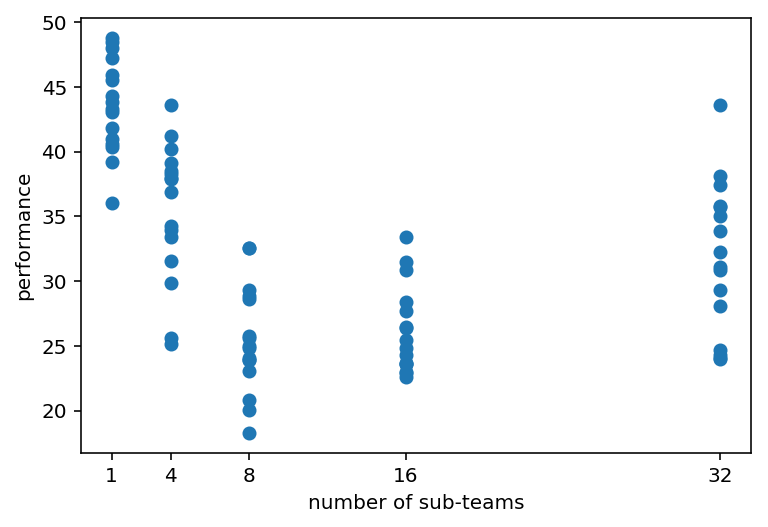

In [120]:
# #plot score vs structure for different team sizes
# for i in range(len(teamSizes)):
#     nAgents = [len(team.agents) for teamSet in teamObjects[i] for team in teamSet]
#     nTeams = [len(team.specializations) for teamSet in teamObjects[i] for team in teamSet]
#     teamScore =  [team.getBestScore() for teamSet in teamObjects[i] for team in teamSet]
#     print("team size %s in %s dim space: " % (teamSizes[i],nDims))
#     plt.scatter(nTeams,teamScore)
#     plt.xlabel("number of sub-teams")
#     plt.xticks([1,4,8,16,32])
#     plt.ylabel("performance")
# #     plt.savefig("../Downloads/optimal_team_size.png",dpi=300)
#     plt.show()


In [153]:
## same experiment, but with diverse team

In [122]:
# t0 = timer.time()
# resetDefaultParameters()
# curatedTeams = True

# teamSizes = [32]#,16,24,32]
# teamDivisions = [1,4,8,16,32]
# nDims = 32

# pComm = 0.2 # np.linspace(0,.5,10)

# steps = 100 #100
# reps = 16
# aiScores = np.linspace(60,140,7)
# aiRange = 50
# aiRanges = np.linspace(0,50,5)
# aiScore = 100

# meetingTimes = 20 

# #choose one problem
# ROUGHNESS = 1
# AVG_SPEED = .01

# resultMatrix = []
# teamObjects = []
# for nAgents in teamSizes:
#     scoresA = []
#     teams = []
#     for nTeams in teamDivisions: 
#         agentTeams = specializedTeams(nAgents,nTeams)
#         teamDims = teamDimensions(nDims,nTeams)
#         if __name__ == '__main__':
#             pool = multiprocessing.Pool(processes = 4)
#             allTeams = pool.map(teamWorkProcess, range(reps))
#             scoresA.append([t.getBestScore() for t in allTeams])
#             teams.append(allTeams)
#     resultMatrix.append(scoresA)
#     teamObjects.append(teams)
#     print("completed one")
# print("time to complete: "+str(timer.time()-t0))


completed one
time to complete: 54.276626110076904


Diverse team, size 32 in 32 dim space: 


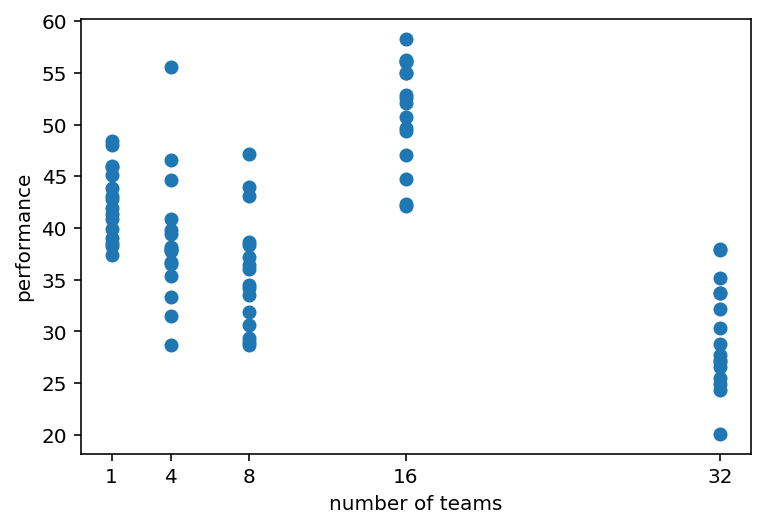

In [123]:
# #plot score vs structure for different team sizes
# for i in range(len(teamSizes)):
#     nAgents = [len(team.agents) for teamSet in teamObjects[i] for team in teamSet]
#     nTeams = [len(team.specializations) for teamSet in teamObjects[i] for team in teamSet]
#     teamScore =  [team.getBestScore() for teamSet in teamObjects[i] for team in teamSet]
#     print("Diverse team, size %s in %s dim space: " % (teamSizes[i],nDims))
#     plt.scatter(nTeams,teamScore)
#     plt.xlabel("number of teams")
#     plt.xticks([1,4,8,16,32])
#     plt.ylabel("performance")
#     plt.savefig("../Downloads/optimal_team_size_diverse.png",dpi=300)
#     plt.show()

# Test Robustness vs diversity

In [243]:
# t0 = timer.time()
# resetDefaultParameters()
# nAgents = 6
# nTeams = 2
# nDims = 10
# steps = 100
# curatedTeams = True

# reps = 16

# allTeams = []
# allTeamScores = []
# aiScore = 100
# aiRanges = [0,20,40,60,80]# np.linspace(0,60,2)

# meetingTimes = 20
# pComm = 0.2

# problemSet = [[.2,.5,1,2,5],[.001,.005,.01,.02,.05]]

# for aiRange in aiRanges:
#     teams = []
#     teamScores = []
#     for i in range(reps):
#         scores, t = robustnessTest(problemSet)
#         teams.append(t)
#         teamScores.append(scores)
#     allTeams.append(teams)
#     allTeamScores.append(teamScores)
#     print('next')
# print('time: %s' % (timer.time() - t0))

next
next
next
next
next
time: 87.78278875350952


In [254]:
# teams = [ t for tt in allTeams for t in tt]
# directory = saveResults(teams,'robustnessForProblems1to5')

In [255]:
# #NORMALIZE for each problem!
# problemMeans = [ np.mean(allTeamScores[:][:][i]) for i in range(len(problemSet[0]))]
# problemSds = [ np.std(allTeamScores[:][:][i]) for i in range(len(problemSet[0]))]
# allTeamScoresStandardized = allTeamScores
# for j in range(len(allTeamScoresStandardized)):
#     for i in range(len(problemSet[0])):
#         allTeamScores[j][:][i] = (allTeamScores[j][:][i]-problemMeans[i])/problemSds[i]
# np.shape(allTeamScoresStandardized)

(5, 16, 5)

In [256]:
# meanScores = [ np.mean(t) for teamSet in allTeamScoresStandardized for t in teamSet ]
# meanGrouped = [ [np.mean(t) for t in teamSet] for teamSet in allTeamScoresStandardized]
# sdScores = [ np.std(t) for teamSet in allTeamScoresStandardized for t in teamSet ]
# sdGrouped = [ [np.std(t) for t in teamSet] for teamSet in allTeamScoresStandardized]
# ranges = [ t.dAI for teamSet in allTeams for t in teamSet ]
# robustness = np.array(meanScores)-np.array(sdScores)
# robustnessGrouped = np.array(meanGrouped)-np.array(sdGrouped)

In [257]:
# rScores = [meanScores[i]+sdScores[i] for i in range(len(meanScores))]

significance: p= 0.004362685807475819


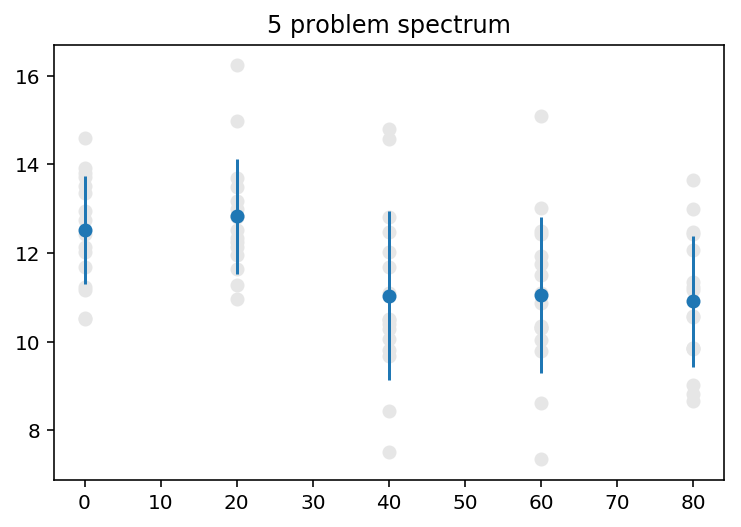

In [258]:
# # plt.scatter(ranges,meanScores)
# plt.scatter(ranges,meanScores,c=[.9,.9,.9])
# plt.title("5 problem spectrum")

# cms = plotCategoricalMeans(ranges, meanScores)
# plt.savefig(directory+"/robustness.png",dpi=300)
# plt.savefig(directory+"/robustness.pdf",dpi=300)


# stat, p = scipy.stats.ttest_ind(robustnessGrouped[0],robustnessGrouped[4])
# print("significance: p= "+str(p))


## robustness for uniform problem set

In [219]:
# t0 = timer.time()
# resetDefaultParameters()
# nAgents = 6
# nTeams = 2
# nDims = 10
# steps = 100
# curatedTeams = True

# reps = 16

# allTeams = []
# allTeamScores = []
# aiScore = 100
# aiRanges = [0,20,40,60,80]# np.linspace(0,60,2)

# meetingTimes = 20
# pComm = 0.2

# problemSet = [[1,1,1],[.01,.01,.01]]

# for aiRange in aiRanges:
#     teams = []
#     teamScores = []
#     for i in range(reps):
#         scores, t = robustnessTest(problemSet)
#         teams.append(t)
#         teamScores.append(scores)
#     allTeams.append(teams)
#     allTeamScores.append(teamScores)
#     print('next')
# print('time: %s' % (timer.time() - t0))

next
next
next
next
next
time: 48.600831031799316


In [240]:
# #NORMALIZE for each problem!
# problemMeans = [ np.mean(allTeamScores[:][:][i]) for i in range(len(problemSet[0]))]
# problemSds = [ np.std(allTeamScores[:][:][i]) for i in range(len(problemSet[0]))]
# allTeamScoresStandardized = allTeamScores
# for j in range(len(allTeamScoresStandardized)):
#     for i in range(len(problemSet[0])):
#         allTeamScores[j][:][i] = (allTeamScores[j][:][i]-problemMeans[i])/problemSds[i]
# np.shape(allTeamScoresStandardized)

(5, 16, 3)

In [241]:
# meanScores = [ np.mean(t) for teamSet in allTeamScoresStandardized for t in teamSet ]
# meanGrouped = [ [np.mean(t) for t in teamSet] for teamSet in allTeamScoresStandardized]
# sdScores = [ np.std(t) for teamSet in allTeamScoresStandardized for t in teamSet ]
# sdGrouped = [ [np.std(t) for t in teamSet] for teamSet in allTeamScoresStandardized]
# ranges = [ t.dAI for teamSet in allTeams for t in teamSet ]
# robustness = np.array(meanScores)-np.array(sdScores)
# robustnessGrouped = np.array(meanGrouped)-np.array(sdGrouped)

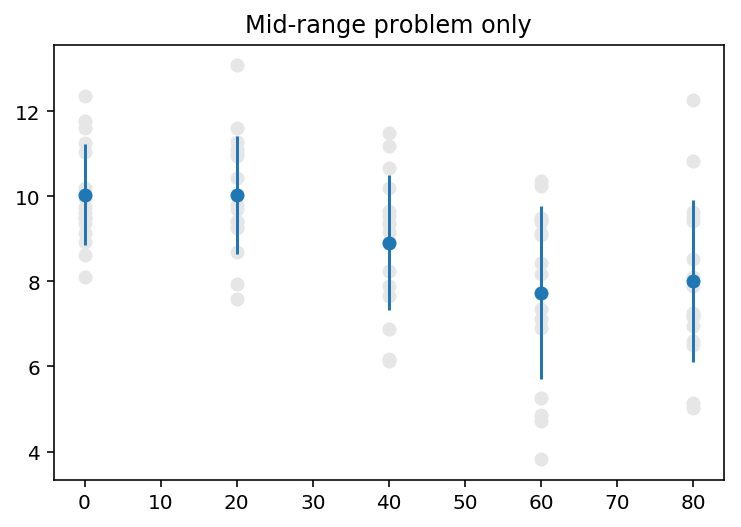

In [242]:
# # plt.scatter(ranges,meanScores)
# plt.scatter(ranges,meanScores,c=[.9,.9,.9])
# plt.title("Mid-range problem only")
# cms = plotCategoricalMeans(ranges, meanScores)

# # stat, p = scipy.stats.ttest_ind(robustnessGrouped[0],robustnessGrouped[4])
# # print("significance: p= "+str(p))